In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
os.chdir('C:/Users/Surya/Desktop/New folder/Temperature Forecasting')

In [3]:
data_dir = '.'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
lines[:] = lines[:10000]
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
9999


In [4]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

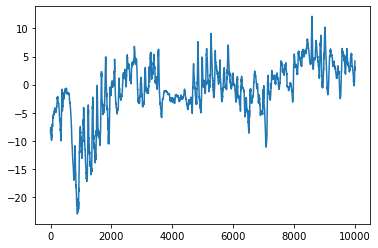

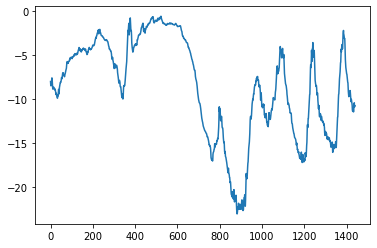

In [5]:
# Plotting the Temperature TimeSeries
%matplotlib inline
import matplotlib.pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.show()

# Plotting the first 10 days of the temperature timeseries
plt.plot(range(1440), temp[:1440])
plt.show()

In [6]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std
float_data.shape

(9999, 14)

In [7]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
            min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows)))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
    

In [8]:
# Preparing the training, validation and test generators
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                     lookback = lookback,
                     delay = delay,
                     min_index = 0,
                     max_index = 2000,
                     shuffle=True,
                     step = step,
                     batch_size = batch_size)

val_gen = generator(float_data,
                   lookback = lookback,
                   delay = delay,
                   min_index = 2001,
                   max_index = 3000,
                   step = step,
                   batch_size=batch_size)

test_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=3001,
                    max_index=None,
                    step = step,
                    batch_size = batch_size)

val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

In [9]:
def evaluation_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluation_naive_method()

C:\Users\Surya\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Surya\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan


In [10]:
# Converting the MAE back to a celcius error
celsius_mae = 0.29 * std[1]
print(celsius_mae)

1.4886517121153695


In [11]:
# Training and evaluating a densely connected model
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/20


C:\Users\Surya\AppData\Local\Temp\ipykernel_19816\457138899.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 105s 209ms/step - loss: 0.3534 - val_loss: 0.0000e+00
Epoch 2/20
500/500 [==============================] - 104s 209ms/step - loss: 0.1999 - val_loss: 0.0000e+00
Epoch 3/20
500/500 [==============================] - 114s 229ms/step - loss: 0.1633 - val_loss: 0.0000e+00
Epoch 4/20
500/500 [==============================] - 105s 211ms/step - loss: 0.1476 - val_loss: 0.0000e+00
Epoch 5/20
500/500 [==============================] - 114s 228ms/step - loss: 0.1358 - val_loss: 0.0000e+00
Epoch 6/20
500/500 [==============================] - 116s 232ms/step - loss: 0.1159 - val_loss: 0.0000e+00
Epoch 7/20
500/500 [==============================] - 114s 229ms/step - loss: 0.0984 - val_loss: 0.0000e+00
Epoch 8/20
500/500 [==============================] - 114s 228ms/step - loss: 0.0908 - val_loss: 0.0000e+00
Epoch 9/20
500/500 [==============================] - 115s 230ms/step - loss: 0.0849 - val_loss: 0.0000e+00
Epoch 10/20
500/500 [==================